# PART ONE

# QUESTION: 

• DOMAIN: Entertainment

• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.

• DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.

• PROJECT OBJECTIVE: Face detection from training images.

    Steps and tasks: [ Total Score: points]
        1. Import the dataset.
        2. Create features (images) and labels (mask) using that data.
        3. Mask detection model:
            ● Design a face mask detection model.
                Hint: Use U-net along with pre-trained transfer learning models
            ● Design your own Dice Coe"icient and Loss function.
            ● Train, tune and test the model.
            ● Evaluate the model using testing data.
        4. Use the “Prediction image” as an input to your designed model and display the output of the image.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Import the dataset.

In [ ]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.8.0'

In [ ]:
import os
import pathlib
import datetime as dt
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2 as cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import tensorflow as tf
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout   #, Rescaling, ZeroPadding2D
from tensorflow.keras.models import Sequential, Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.losses

from tensorflow.keras.models import load_model

**Setting up the project path and loading the image array from npy file**

In [ ]:
project_path = "/content/drive/My Drive/aiml/cv/project2/"

img_array = np.load(project_path +'images.npy', allow_pickle=True)

print("Dataset loaded successfully")

KeyboardInterrupt: ignored

In [ ]:
img_array.shape

(409, 2)

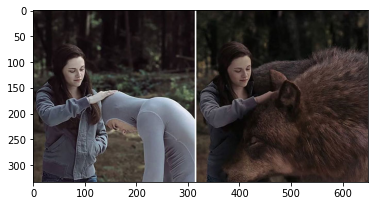

In [ ]:
image1 = img_array[0][0]
plt.imshow(image1)

In [ ]:
print(img_array[0][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063}, {'x': 0.1723076923076923, 'y': 0.45345345345345345}], 'imageWidth': 650, 'imageHeight': 333}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913}, {'x': 0.6584615384615384, 'y': 0.46846846846846846}], 'imageWidth': 650, 'imageHeight': 333}]


**Set image dimensions**

In [ ]:

ALPHA = 1
IMAGE_SIZE = 224
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

### 2. Create features (images) and labels (mask) using that data.

> * Here feature is the image
> * The label is the mask
> * Images will be stored in "X_train" array
> * Masks will be stored in "masks" array

In [ ]:
masks = np.zeros((int(img_array.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(img_array.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(img_array.shape[0]):
    img = img_array[index][0]
    img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype = np.float32))
    for i in img_array[index][1]:
        x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
        x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
        y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

**Print the shape of X_train and mask array**

In [ ]:
X.shape


(409, 224, 224, 3)

In [ ]:
masks.shape


(409, 224, 224)

**Print a sample image and image array**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

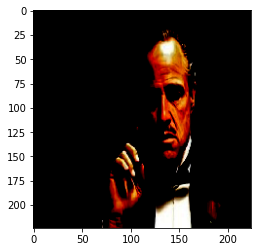

In [ ]:
n = 10
print(X[n])
plt.imshow(X[n])

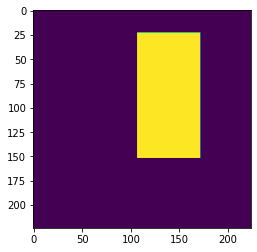

In [ ]:
plt.imshow(masks[n])


### 3. Mask detection model:
            ● Design a face mask detection model.
                Hint: Use U-net along with pre-trained transfer learning models
            ● Design your own Dice Coe"icient and Loss function.
            ● Train, tune and test the model.
            ● Evaluate the model using testing data.

**Design a face mask detection model.**

In [ ]:
def create_model(trainable=True):
     #### code added below ####
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")
    
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    #### code added below ####

    # Since mask size is 224 (same as input), we need to concatenate it back all 6 layers, i.e layers of sizes 7,14,28,56,112 & 224, bottom onwards
    block1 = model.get_layer("input_1").output         #224
    block2 = model.get_layer("conv_pw_1_relu").output  #112
    block3 = model.get_layer("conv_pw_3_relu").output  #56
    block4 = model.get_layer("conv_pw_5_relu").output  #28
    block5 = model.get_layer("conv_pw_11_relu").output #14
    block6 = model.get_layer("conv_pw_13_relu").output #7

    x = Concatenate()([UpSampling2D()(block6), block5])
    x = Concatenate()([UpSampling2D()(x), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
 
    # Add new top layer which is an sigmoid activation layer that gives 1 or 0 depending on inside/outside the face
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
 
    return Model(inputs=model.input, outputs=x)

In [ ]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model(trainable=True)

# Print summary
model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                             

**Design your own Dice Coe"icient and Loss function.**

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

**Train, tune and test the model.**

In [ ]:
optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [ ]:
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [ ]:
tf.config.run_functions_eagerly(True)


**Evaluate the model using testing data.**

**Fit the model**

> Fit the model using below parameters.    
> epochs: you can decide.       
> batch_size: 1.     
> callbacks: checkpoint, reduce_lr, stop.   

In [ ]:

model.fit(x=X,y=masks,
          epochs=20, batch_size=1,
          callbacks=[checkpoint, reduce_lr, stop],
           use_multiprocessing=True, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Streaming output truncated to the last 5000 lines.
370/409 [==========================>...] - ETA: 7s - loss: 0.3914 - dice_coefficient: 0.7867
Epoch 14: loss did not improve from 0.09831
371/409 [==========================>...] - ETA: 7s - loss: 0.3911 - dice_coefficient: 0.7867
Epoch 14: loss did not improve from 0.09831
372/409 [==========================>...] - ETA: 7s - loss: 0.3905 - dice_coefficient: 0.7869
Epoch 14: loss did not improve from 0.09831
373/409 [==========================>...] - ETA: 6s - loss: 0.3903 - dice_coefficient: 0.7870
Epoch 14: loss did not improve from 0.09831
374/409 [==========================>...] - ETA: 6s - loss: 0.3899 - dice_coefficient: 0.7872
Epoch 14: loss did not improve from 0.09831
375/409 [==========================>...] - ETA: 6s - loss: 0.3896 - dice_coefficient: 0.7873
Epoch 14: loss did not improve from 0.09831
376/409 [==========================>...] - ETA: 6s - loss: 0.3901 - dice_coefficient: 0.7868
Epoch 14: loss did not improve fro

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Sample Image: 10


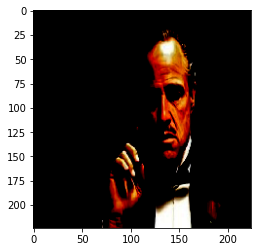


 Given Mask: 10


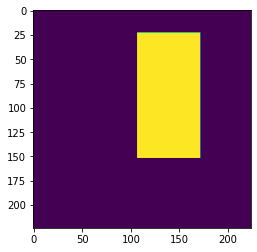


 Predicted Mask: 10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


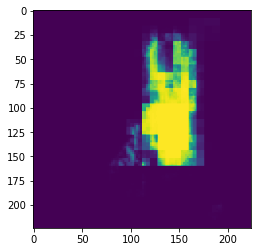

In [ ]:
n = 10
sample_image = X[n]

#### Code below ####
print("\n Sample Image: "+ str(n)) # Sample image
plt.imshow(sample_image) 
plt.show()

print("\n Given Mask: "+ str(n)) # Given Mask
plt.imshow(masks[n])
plt.show()

print("\n Predicted Mask: "+ str(n)) # Predicted Mask
a=model.predict(sample_image.reshape(1,224,224,3))
plt.imshow(a.reshape(224,224)) 
plt.show()

### 4. Use the “Prediction image” as an input to your designed model and display the output of the image.

Each image in the data set has a same of (500, 500, 3)

 Sample Image: 


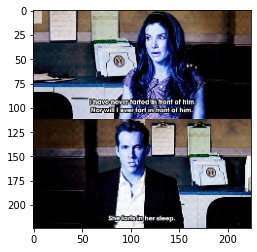


 Given Mask: 


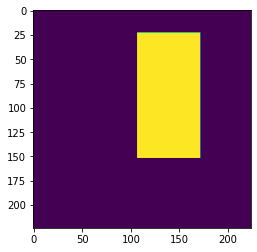


 Predicted Mask: 


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


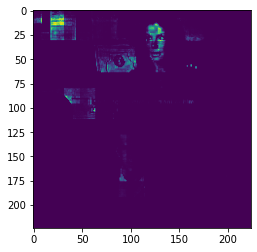

In [ ]:
img = cv2.imread(project_path + 'Part 1Test Data - Prediction Image.jpeg')
print("Each image in the data set has a same of {0}".format(img.shape))
img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
sample_image = img[:, :, :3]

#### Code below ####
print("\n Sample Image: ") # Sample image
plt.imshow(sample_image) 
plt.show()

print("\n Given Mask: ") # Given Mask
plt.imshow(masks[n])
plt.show()

print("\n Predicted Mask: ") # Predicted Mask
a=model.predict(sample_image.reshape(1,224,224,3))
plt.imshow(a.reshape(224,224)) 
plt.show()

# PART TWO

# QUESTION: 

• DOMAIN: Face recognition

• CONTEXT: Company X intends to build a face identi!ication model to recognise human faces.

• DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.

• PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library. Some data samples:

• TASK: In this problem, we use a pre-trained model trained on Face recognition to recognise similar faces. Here, we are particularly interested in recognising whether two given faces are of the same person or not. Below are the steps involved in the project.

    • Load the dataset and create the metadata.
    • Check some samples of metadata.
    • Load the pre-trained model and weights.
    • Generate Embedding vectors for each face in the dataset.
    • Build distance metrics for identifying the distance between two given images.
    • Use PCA for dimensionality reduction.
    • Build an SVM classi!ier in order to map each image to its right person.
    • Import the the test image. Display the image. Use the SVM trained model to predict the face.

**Project Description:**
The goal is to build a face identification model to recognize faces.

**Data Description:**
Aligned Face Dataset from Pinterest

This dataset contains 10,770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library.

**Objective:**
In this problem, we use a pre-trained model trained on Face recognition to recognize similar faces. Here, we are particularly interested in recognizing whether two given faces are of the same person or not.

• **Load the dataset and create the metadata.**

> Importing the packages

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from zipfile import ZipFile
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score
from tensorflow.keras.models import Model

# used to supress display of warnings
import warnings
warnings.filterwarnings('ignore')


> Change current working directory to project folder. 

In [ ]:
project_path = "/content/drive/My Drive/aiml/cv/project2/"

In [ ]:
os.chdir(project_path)

In [ ]:
print(os.getcwd())


/content/drive/My Drive/aiml/cv/project2


> Extract the zip file

In [ ]:
with ZipFile('Aligned+Face+Dataset+from+Pinterest+-+CV+project+1.zip', 'r') as z:
  z.extractall()

In [ ]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata("PINS")

**• Check some samples of metadata.**

> Checking metadata shape

In [ ]:
print('metadata shape :', metadata.shape)


metadata shape : (10544,)


> Check metadata 1500

In [ ]:
metadata[1500]


PINS/pins_Danielle Panabaker/Danielle Panabaker78.jpg

In [ ]:
type(metadata[1500]), metadata[1500].image_path()


(__main__.IdentityMetadata,
 'PINS/pins_Danielle Panabaker/Danielle Panabaker78.jpg')

> Define a function to load an image


In [ ]:
def load_image(path):
    img = cv2.imread(path, 1)
    plt.imshow(img)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

> Load a sample image 

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

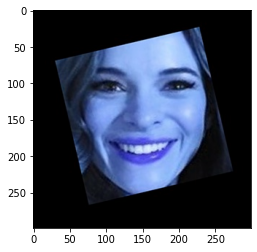

In [ ]:
load_image(metadata[1500].image_path())

**• Load the pre-trained model and weights.**

Here we are giving you the predefined model for VGG face

In [ ]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

> > Load the model defined above


> > Then load the given weight file named "vgg_face_weights.h5"






In [ ]:
model = vgg_face()

model.load_weights('vgg_face_weights.h5')

> Get vgg_face_descriptor

In [ ]:
model.layers[0], model.layers[-2]

(<keras.layers.convolutional.ZeroPadding2D at 0x7f29c83ba790>,
 <keras.layers.core.flatten.Flatten at 0x7f29c3d1c3d0>)

In [ ]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [ ]:
type(vgg_face_descriptor)

keras.engine.functional.Functional

In [ ]:
vgg_face_descriptor.inputs, vgg_face_descriptor.outputs

([<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'zero_padding2d_input')>],
 [<KerasTensor: shape=(None, 2622) dtype=float32 (created by layer 'flatten')>])

**• Generate Embedding vectors for each face in the dataset.**

> Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model.

(224, 224, 3)
(2622,)


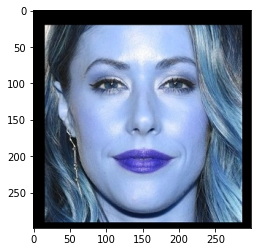

In [ ]:
img_path = metadata[0].image_path()
img = load_image(img_path)

img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
print(img.shape)

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

In [ ]:
embedding_vector[0], type(embedding_vector), type(embedding_vector[0])

(0.014018936, numpy.ndarray, numpy.float32)

In [ ]:
embedding_vector[2], embedding_vector[98], embedding_vector[-2]

(0.0020015764, -0.0071871257, 0.00816727)

**Generate embeddings for all images**

> Write code to iterate through metadata and create embeddings for each image using vgg_face_descriptor.predict() and store in a list with name embeddings

> If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [ ]:
total_images = len(metadata)

print('total_images :', total_images)

total_images : 10544


KeyboardInterrupt: ignored

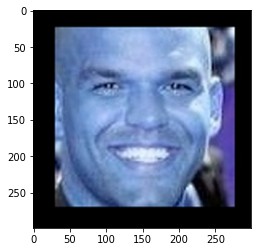

In [ ]:
embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    img_path = metadata[i].image_path()
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embeddings[i]=embedding_vector

In [ ]:
print('embeddings shape :', embeddings.shape)

In [ ]:
embeddings[0], embeddings[988], embeddings[988].shape

In [ ]:
embeddings[8275]

**• Build distance metrics for identifying the distance between two given images.**

1. Consider distance metric as "Squared L2 distance"
2. Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

> Plot images and get distance between the pairs

900, 901 and 900, 1001

1100, 1101 and 1100, 1300

1407, 1408 and 1408, 1602

In [ ]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance between {idx1} & {idx2}= {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(900, 901)
show_pair(900, 1001)

In [ ]:
show_pair(1100, 1101)
show_pair(1100, 1300)

In [ ]:
show_pair(1407, 1408)
show_pair(1408, 1602)

Create train and test sets

> Create X_train, X_test and y_train, y_test

> Use train_idx to seperate out training features and labels

> Use test_idx to seperate out testing features and labels

In [ ]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]

# another half as test examples of 10 identities
X_test = embeddings[test_idx]
targets = np.array([m.name for m in metadata])

#train labels
y_train = targets[train_idx]

#test labels
y_test = targets[test_idx]

In [ ]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

In [ ]:
y_test[0], y_train[988]

In [ ]:
len(np.unique(y_test)), len(np.unique(y_train))

Encode the Labels

> Encode the targets

> Use LabelEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)


In [ ]:
print(le.classes_)
y_test_encoded = le.transform(y_test)

In [ ]:
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)

Standardize the feature values

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [ ]:
X_test_std = scaler.transform(X_test)

**Reduce dimensions using PCA**

> Reduce feature dimensions using Principal Component Analysis

> Set the parameter n_components=128

In [ ]:
print('X_train_std shape : ({0},{1})'.format(X_train_std.shape[0], X_train_std.shape[1]))
print('y_train_encoded shape : ({0},)'.format(y_train_encoded.shape[0]))
print('X_test_std shape : ({0},{1})'.format(X_test_std.shape[0], X_test_std.shape[1]))
print('y_test_encoded shape : ({0},)'.format(y_test_encoded.shape[0]))

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

### • Build an SVM classi!ier in order to map each image to its right person. 

**Model Building and Validation**

> Use SVM Classifier to predict the person in the given image

> Fit the classifier and print the score

In [ ]:
from sklearn.svm import SVC

clf = SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train_encoded)

In [ ]:
y_predict = clf.predict(X_test_pca)


In [ ]:
print('y_predict : ',y_predict)
print('y_test_encoded : ',y_test_encoded)

In [ ]:
y_predict_encoded = le.inverse_transform(y_predict)

In [ ]:
print('y_predict_encoded : ',y_predict_encoded)

In [ ]:
print('y_predict shape : ', y_predict.shape)
print('y_test_encoded shape : ', y_test_encoded.shape)

In [ ]:
y_test_encoded[32:49]

In [ ]:
# Find the classification accuracy
accuracy_score(y_test_encoded, y_predict)

### • Import the the test image. Display the image. Use the SVM trained model to predict the face.

> Take 10th image from test set and plot the image

> Report to which person(folder name in dataset) the image belongs to

In [ ]:
example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_predict_encoded[example_idx]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

In [ ]:
img_path = "Part 2 - Test Image - Dwayne Johnson4.jpg"
img = load_image(img_path)
img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)




In [ ]:
X_std = scaler.transform([embedding_vector])
X_pca = pca.transform(X_std)
y_res = clf.predict(X_pca)

In [ ]:
y_res

In [ ]:
example_prediction = y_res
example_identity =  y_predict_encoded[89]

plt.imshow(img)
plt.title(f'Identified as {example_identity}');

# CONCLUSION


* This dataset contains 17534 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library.

* Generated embeddings for all images using pre-trained VGG Face model.

* Used "Squared L2 distance" to calculate the distance between given 2 pairs of images.

* Encoded the target variables, standardize the features and reduced dimensions using PCA.

* Used SVM classifier to predict the celebrity in a given image and achived a 95% accuracy.